- Trades @ close
- Comisión = 0.125%
- SL = TP = 5%
- Cash = $1M
- N Shares = 50
- No taxes
- No leverages
- Margin Acc = 50%
- Borrow rate = 0.25%
- Timeframe = 5 minutes

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ta
import optuna
import warnings
warnings.filterwarnings("ignore")


sns.set_theme()

In [135]:
from dataclasses import dataclass

@dataclass
class Operation:
    time: str
    price: float
    stop_loss: float
    take_profit: float
    n_shares: int
    type: str
    margin_req: float
    margin_acc: float

In [136]:
def get_portfolio_value(cash: float, long_ops: list[Operation], short_ops: list[Operation], current_price: float, n_shares: int, COM : float) -> float:
    val = cash

    # add long positions value
    val += len(long_ops) * n_shares * current_price

    #add short positions value
    for position in short_ops:
        cover_buy = current_price * position.n_shares * (1 + COM)
        val += position.margin_acc + position.margin_req - cover_buy

    return val

In [137]:
data = pd.read_csv('aapl_5m_train.csv').dropna()
data.head()

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume
0,0,1609770600,0,2021-01-04 14:30:00,133.570007,133.611602,132.389999,132.809997,6624663.0
1,1,1609770900,0,2021-01-04 14:35:00,132.750000,132.750000,131.809997,131.889999,2541553.0
2,2,1609771200,0,2021-01-04 14:40:00,131.500000,132.339996,131.500000,132.059997,2492415.0
3,3,1609771500,0,2021-01-04 14:45:00,132.000000,132.250000,131.899993,132.250000,1859131.0
4,4,1609771800,0,2021-01-04 14:50:00,132.000000,132.018096,131.520004,131.589996,1780105.0


In [138]:
rsi_indicator = ta.momentum.RSIIndicator(data.Close, window=25)
data['RSI'] = rsi_indicator.rsi()

In [139]:
historic = data.dropna()
historic['buy_signal'] = historic.RSI < 24
historic['sell_signal'] = historic.RSI > 79

In [140]:
COM = 0.125 / 100
SL = 0.07
TP = 0.07
BORROW_RATE = 0.25 / 100
MARGIN = 0.5
MIN_MARGIN = 0.25
ADJUSTED_BORROW_RATE = BORROW_RATE / (252 * 6.5 * 60 / 5)

cash = 1_000_000
n_shares = 250

active_long_positions: list[Operation] = []
active_short_positions: list[Operation] = [] 

portfolio_value = [cash]

for i, row in historic.iterrows():

    # SHORT positions
    
    for position in active_short_positions.copy():
        cover_buy = row.Close * position.n_shares * (1 + COM)
        position.margin_acc -= row.Close * position.n_shares * ADJUSTED_BORROW_RATE 
        equity = position.margin_acc + position.margin_req - cover_buy
        req_equity = MIN_MARGIN * cover_buy

        # check if there is a margin call

        if equity < req_equity:
            margin_call = req_equity - equity
            position.margin_acc += margin_call
            
            # check if you have enough cash to cover the margin call

            if cash >= margin_call:
                cash -= margin_call
                position.margin_acc += margin_call
            else:
                cash += position.margin_acc + position.margin_req - cover_buy
                active_short_positions.remove(position)
                continue

        # close positions

        if row.Close < position.take_profit or row.Close > position.stop_loss:
            cash += position.margin_acc + position.margin_req - cover_buy
            active_short_positions.remove(position)
            continue

    # check signal 

    if not row.sell_signal:
        portfolio_value.append(get_portfolio_value(cash, active_long_positions, active_short_positions, row.Close, n_shares, COM))
        continue  

    # check if you have enough cash to cover the required margin

    margin_req = row.Close * n_shares * MARGIN 
    if  not cash > margin_req:
        portfolio_value.append(get_portfolio_value(cash, active_long_positions, active_short_positions, row.Close, n_shares))
        continue  

    # discount the cost 

    margin_acc = row.Close * n_shares * (1 - COM)  
    cash -= margin_req  

    # save the operation as active position

    active_short_positions.append(
        Operation(
            time=row.Datetime,
            price=row.Close,
            stop_loss=row.Close * (1 + SL),
            take_profit=row.Close * (1 - TP),
            n_shares=n_shares,
            type='SHORT',
            margin_req=margin_req,
            margin_acc=margin_acc
        )
    )

    portfolio_value.append(get_portfolio_value(cash, active_long_positions, active_short_positions, row.Close, n_shares, COM))

  
    # LONG positions
    

    # close positions 

    for position in active_long_positions.copy():
        if row.Close > position.take_profit or row.Close < position.stop_loss:
            cash += row.Close * position.n_shares * (1 - COM)
            active_long_positions.remove(position)

    # check signal 

    if not row.buy_signal:
        portfolio_value.append(get_portfolio_value(cash, active_long_positions, active_short_positions, row.Close, n_shares, COM))
        continue
    
    # check if you have enough cash

    if cash < row.Close * n_shares * (1 + COM):
        portfolio_value.append(get_portfolio_value(cash, active_long_positions, active_short_positions, row.Close, n_shares, COM))
        continue

    # discount the cost 

    cash -= row.Close * n_shares * (1 + COM)

    # save the operation as active position

    active_long_positions.append(
        Operation(
            time=row.Datetime,
            price=row.Close,
            stop_loss=row.Close * (1 - SL),
            take_profit=row.Close * (1 + TP),
            n_shares=n_shares,
            type='LONG',
            margin_req=0,
            margin_acc=0
            
        )
    )

    portfolio_value.append(get_portfolio_value(cash, active_long_positions, active_short_positions, row.Close, n_shares, COM))

# Close all the positions

cash += row.Close * len(active_long_positions) * n_shares * (1 - COM)
active_long_positions = []

for position in active_short_positions:
    cash -= row.Close * position.n_shares * (1 + COM)  
    cash += position.margin_acc + position.margin_req  - cover_buy
active_short_positions = []


In [141]:
cash

1033427.1199052855

<Axes: >

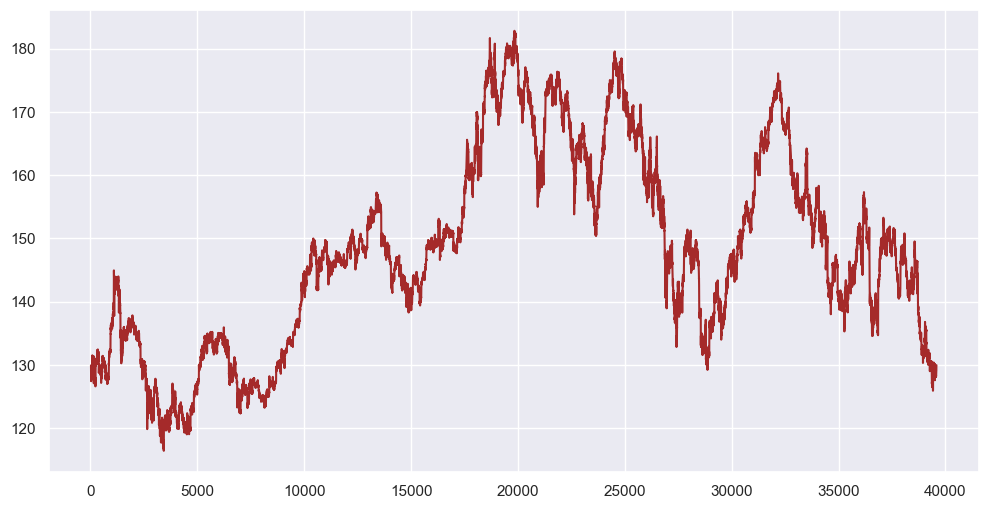

In [142]:
historic.Close.plot(figsize=(12,6), color = 'brown')

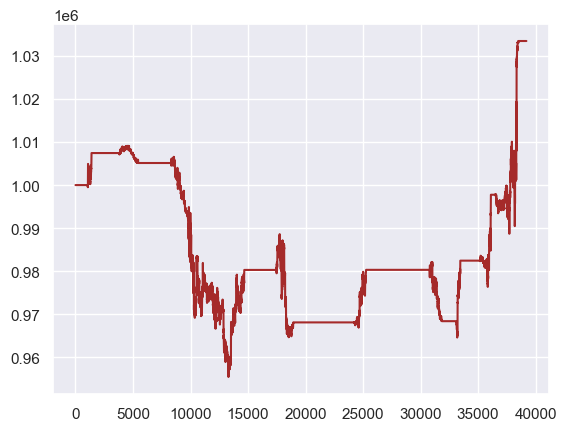

In [143]:
plt.plot(portfolio_value, color='brown')

In [144]:
from dataclasses import dataclass
import ta

# --- Definición de operación ---
@dataclass
class Operation:
    time: str
    price: float
    stop_loss: float
    take_profit: float
    n_shares: int
    type: str
    margin_req: float
    proceeds: float   # lo que aportó al margin_account

# --- Valor de portafolio ---
def get_portfolio_value(cash, long_ops, short_ops, current_price, n_shares, COM, margin_account):
    val = cash

    # valor de largos
    for position in long_ops:
        val += current_price * position.n_shares

    # valor de cortos (global)
    total_cover = sum(current_price * p.n_shares * (1 + COM) for p in short_ops)
    total_margin_req = sum(p.margin_req for p in short_ops)
    val += margin_account + total_margin_req - total_cover

    return val

# --- RSI y señales ---
rsi_indicator = ta.momentum.RSIIndicator(data.Close, window=25)
data['RSI'] = rsi_indicator.rsi()

historic = data.dropna()
historic['buy_signal'] = historic.RSI < 24
historic['sell_signal'] = historic.RSI > 79

# --- Parámetros ---
COM = 0.125 / 100
SL = 0.45
TP = 0.07
BORROW_RATE = 0.25 / 100
MARGIN = 0.5
MIN_MARGIN = 0.25
ADJUSTED_BORROW_RATE = BORROW_RATE / (252 * 6.5 * 60 / 5)

cash = 1_000_000
n_shares = 250

active_long_positions: list[Operation] = []
active_short_positions: list[Operation] = []

portfolio_value = [cash]
margin_account = 0  # cuenta global

# --- Bucle principal ---
for i, row in historic.iterrows():

    # --- Revisar largos ---
    for position in active_long_positions.copy():
        if row.Close > position.take_profit or row.Close < position.stop_loss:
            cash += row.Close * position.n_shares * (1 - COM)
            active_long_positions.remove(position)

    # --- Revisar cortos ---
    for position in active_short_positions.copy():
        cover_buy = row.Close * position.n_shares * (1 + COM)

        # pagar intereses de esta posición
        margin_account -= row.Close * position.n_shares * ADJUSTED_BORROW_RATE 

        # equity global (cuenta margen + reqs - costo cubrir todo)
        total_cover = sum(row.Close * p.n_shares * (1 + COM) for p in active_short_positions)
        total_margin_req = sum(p.margin_req for p in active_short_positions)
        equity = margin_account + total_margin_req - total_cover
        req_equity = MIN_MARGIN * cover_buy

        # margin call global
        if equity < req_equity:
            margin_call = req_equity - equity
            print(f"MARGIN CALL en {row.Datetime}: faltan {margin_call:.2f}")

            if cash >= margin_call:
                cash -= margin_call
                margin_account += margin_call
            else:
                # liquidar esta posición si no hay efectivo suficiente
                margin_account -= position.proceeds
                cash += position.proceeds + position.margin_req - cover_buy
                active_short_positions.remove(position)
                continue

        # cierre SL / TP
        if row.Close < position.take_profit or row.Close > position.stop_loss:
            margin_account -= position.proceeds
            cash += position.proceeds + position.margin_req - cover_buy
            active_short_positions.remove(position)
            continue

    # --- Entrada LONG ---
    if row.buy_signal:
        if cash >= row.Close * n_shares * (1 + COM):
            cash -= row.Close * n_shares * (1 + COM)
            active_long_positions.append(
                Operation(
                    time=row.Datetime,
                    price=row.Close,
                    stop_loss=row.Close * (1 - SL),
                    take_profit=row.Close * (1 + TP),
                    n_shares=n_shares,
                    type='LONG',
                    margin_req=0,
                    proceeds=0
                )
            )

    # --- Entrada SHORT ---
    if row.sell_signal:
        margin_req = row.Close * n_shares * MARGIN
        if cash >= margin_req:
            proceeds = row.Close * n_shares * (1 - COM)
            margin_account += proceeds
            cash -= margin_req

            active_short_positions.append(
                Operation(
                    time=row.Datetime,
                    price=row.Close,
                    stop_loss=row.Close * (1 + SL),
                    take_profit=row.Close * (1 - TP),
                    n_shares=n_shares,
                    type='SHORT',
                    margin_req=margin_req,
                    proceeds=proceeds
                )
            )

    # --- Actualizar valor del portafolio ---
    portfolio_value.append(
        get_portfolio_value(
            cash, active_long_positions, active_short_positions,
            row.Close, n_shares, COM, margin_account
        )
    )

# --- Cierre final ---
# cerrar largos
for position in active_long_positions:
    cash += position.n_shares * row.Close * (1 - COM)
active_long_positions = []

# cerrar cortos
for position in active_short_positions:
    cover_buy = row.Close * position.n_shares * (1 + COM)
    margin_account -= position.proceeds
    cash += position.proceeds + position.margin_req - cover_buy
active_short_positions = []

margin_account = 0


In [145]:
cash


1355163.4216906247